Submitted by:

Sharath Kumar Krishnayya Ravindra

Roshan Rayala Bhaskar

Shashankh Mysore Girish

Referred to: https://www.aitude.com/implement-non-linear-independent-components-estimation-with-tensorflow/

Model Architecture:-

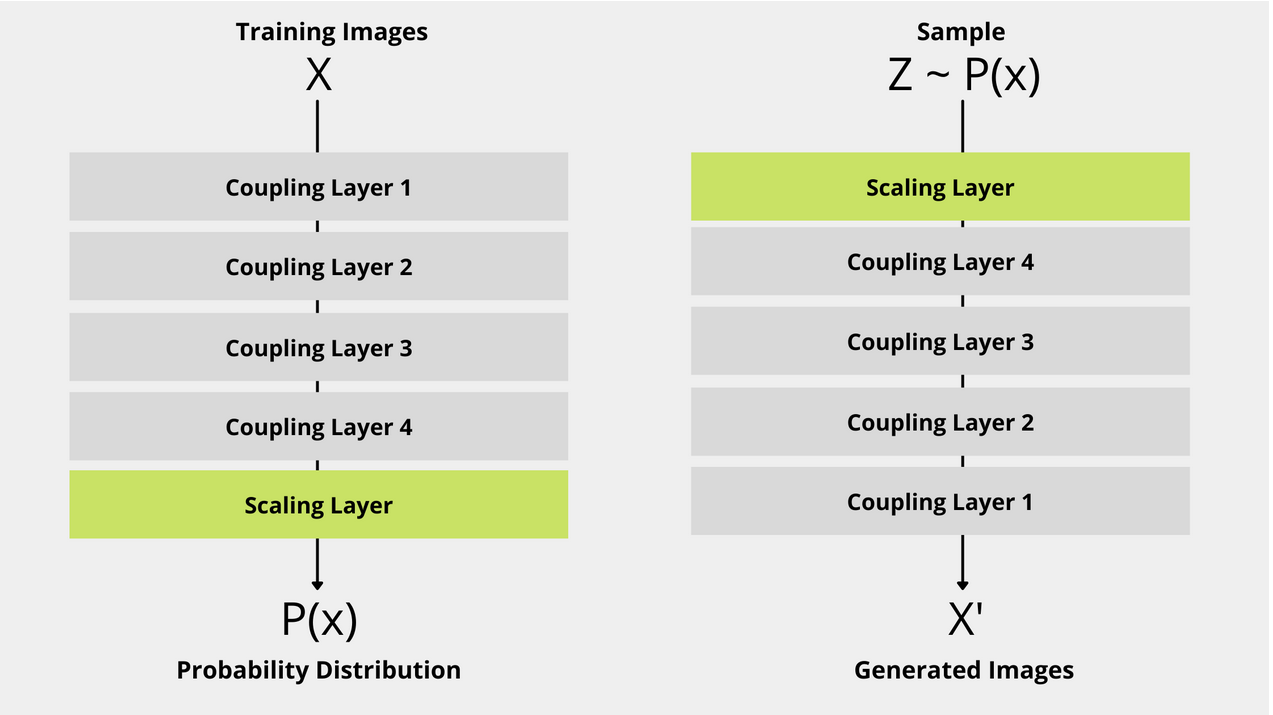

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class CouplingLayer(layers.Layer):

	#This method define the neural network to learn function F


	def __init__(self,input_dim, hidden_dim, partition, num_hidden_layers):

		super(CouplingLayer, self).__init__()

		assert input_dim % 2 == 0

		self.partition = partition # Posssible values - odd or even

		# Define Neural Network

		inputs = keras.Input(shape = (input_dim))

		x = inputs
		for layer in range(num_hidden_layers):
			x = layers.Dense(hidden_dim)(x)
			x = layers.LeakyReLU()(x)

		outputs = layers.Dense(input_dim, activation='linear')(x)
		self.m = keras.Model( inputs = inputs, outputs = outputs)

		# Define lambda functions to get odd or even indexed data.
		if self.partition == 'even':
			self._first = lambda xs: xs[:,0::2]
			self._second = lambda xs: xs[:,1::2]
		else:
			self._first = lambda xs: xs[:,1::2]
			self._second = lambda xs: xs[:,0::2]

	""" This method implement additive coupling layer operations.
	y1 = x1
	y2 = x2 + m(x1)
  """

	def call(self,inputs):

		# Split input into two parts x1 and x2
		x1 = self._first(inputs)
		x2 = self._second(inputs)

		# Inference latent representation
		y1 = x1
		y2 = x2 + self.m(x1)

		# Merge both y1 and y2 using interleave method. e.g y1 = [1,3,5,7,9] and y2 = [2,4,6,8,10] then y = [1,2,3,4,5,6,7,8,9,10]
		if self.partition == 'even':
		  y = tf.reshape(tf.concat([y1[...,tf.newaxis], y2[...,tf.newaxis]], axis=-1), [tf.shape(y1)[0],-1])

		else:
		  y = tf.reshape(tf.concat([y2[...,tf.newaxis], y1[...,tf.newaxis]], axis=-1), [tf.shape(y2)[0],-1])

		return y

	#This function will generate new image using latent variable
	def inverse(self,latent_variable):

		y1 = self._first(latent_variable)
		y2 = self._second(latent_variable)
		x1,x2 = y1, y2 - self.m(y1)

		if self.partition == 'even':
		  x = tf.reshape(tf.concat([x1[...,tf.newaxis], x2[...,tf.newaxis]], axis=-1), [tf.shape(x1)[0],-1])
		else:
		  x = tf.reshape(tf.concat([x2[...,tf.newaxis], x1[...,tf.newaxis]], axis=-1), [tf.shape(x2)[0],-1])

		return x

In [4]:
class ScalingLayer(layers.Layer):
#This method define the scaling layer with normal distribution.
	def __init__(self,input_dim):
		super(ScalingLayer,self).__init__()
		self.scaling_layer = tf.Variable(tf.random.normal([input_dim]),trainable=True)

#This method rescale the final output of coupling layers.
	def call(self,x):
		return x*tf.transpose(tf.math.exp(self.scaling_layer))

#This method is inverse implementation of the call method.
	def inverse(self,z):
	    return z*tf.transpose(tf.math.exp(-self.scaling_layer))

In [5]:
class NICE(keras.Model):

#This function define trainable model with multiple coupling layers and a scaling layer.
	def __init__(self,input_dim,hidden_dim,num_hidden_layers):

		super(NICE,self).__init__()
		self.input_dim = input_dim
		# Coupling layer will have half dimension of the input data.
		half_dim = int(self.input_dim / 2)

		# Define 4 coupling layers.
		self.coupling_layer1 = CouplingLayer(input_dim=half_dim, hidden_dim = hidden_dim, partition='odd', num_hidden_layers=num_hidden_layers)
		self.coupling_layer2 = CouplingLayer(input_dim=half_dim, hidden_dim = hidden_dim, partition='even', num_hidden_layers=num_hidden_layers)
		self.coupling_layer3 = CouplingLayer(input_dim=half_dim, hidden_dim = hidden_dim, partition='odd', num_hidden_layers=num_hidden_layers)
		self.coupling_layer4 = CouplingLayer(input_dim=half_dim, hidden_dim = hidden_dim, partition='even', num_hidden_layers=num_hidden_layers)

		# Define scaling layer which rescaling the output for more weight variations.
		self.scaling_layer = ScalingLayer(self.input_dim)

#This function calculates the log likelihood.
	def log_likelihood(self, z):
		log_likelihood = tf.reduce_sum(-(tf.math.softplus(z) + tf.math.softplus(-z)), axis=1) + tf.reduce_sum(self.scaling_layer.scaling_layer)
		return log_likelihood

#This function passes input through coupling layer. Scale the output using scaling layer and return latent space z and loglikelihood
	def call(self, x):

		z = self.coupling_layer1(x)
		z = self.coupling_layer2(z)
		z = self.coupling_layer3(z)
		z = self.coupling_layer4(z)
		z = self.scaling_layer(z)

		log_likelihood = self.log_likelihood(z)
		return z,log_likelihood

#Generate sample data using latent space. This is exact inverse of the call method.
	def inverse(self,z):
		x  = z
		x  = self.scaling_layer.inverse(x)
		x  = self.coupling_layer4.inverse(x)
		x  = self.coupling_layer3.inverse(x)
		x  = self.coupling_layer2.inverse(x)
		x  = self.coupling_layer1.inverse(x)

		return x

#Sample out new data from learnt probability distribution
	def sample(self, num_samples):
		z = tf.random.uniform([num_samples, self.input_dim])
		z = tf.math.log(z) - tf.math.log(1.-z)
		return self.inverse(z)

In [6]:
input_data_size = 784 # for mnist dataset. 28*28
num_epochs = 50
batch_size = 256
num_hidden_layer = 5
num_hidden_units = 1000

In [7]:
# Prepare training dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.reshape(-1,input_data_size) + tf.random.uniform([input_data_size])) / 256.0
x_test = (x_test.reshape(-1,input_data_size) + tf.random.uniform([input_data_size])) / 256.0
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(batch_size)
val_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


11490434/11490434 [==============================] - 2s 0us/step


In [15]:
def show_samples(model):
    ys = model.sample(20)
    plt.figure(figsize=(10, 2))
    for i in range(20):
        plt.subplot(2, 10, i + 1)
        plt.axis('off')
        plt.imshow(tf.reshape(ys[i], (28, 28)), cmap="gray")
    plt.show()

In [16]:
#function to execute training steps

def train_model (input_data_size, num_hidden_units, num_hidden_layer, num_epochs):
  model = NICE(input_dim = input_data_size, hidden_dim = num_hidden_units, num_hidden_layers = num_hidden_layer)

  opt = keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0)

  # Iterate through training epoch
  for i in range(num_epochs):

      # Iterate through dataloader
      for batch_id, (x, _) in enumerate(train_loader):

          # Forward Pass
          with tf.GradientTape() as tape:
              z, likelihood = model(x)
              log_likelihood_loss = tf.reduce_mean(likelihood)
              # Convert the maximum likelihood problem into negative of minimum likelihood problem
              loss = -log_likelihood_loss

          # Backward Pass
          gradient = tape.gradient(loss, model.trainable_weights)
          opt.apply_gradients(zip(gradient, model.trainable_weights))

      # Compute and log training loss
      train_log_likelihood_loss = -log_likelihood_loss.numpy()

      # Validation Phase
      val_log_likelihood_loss = 0.0
      num_val_batches = 0

      for x_val, _ in val_loader:
          z_val, likelihood_val = model(x_val)
          val_log_likelihood_loss += tf.reduce_mean(likelihood_val).numpy()
          num_val_batches += 1

      val_log_likelihood_loss /= num_val_batches

      # Log the maximum likelihood after each training loop
      print('Epoch {} completed. Train Log Likelihood: {}. Validation Log Likelihood: {}'.format(i, train_log_likelihood_loss, val_log_likelihood_loss))

      # Generate 20 new images after 10 epochs.
      if i % 10 == 0 and i != 0:
          show_samples(model)

Epoch 0 completed. Train Log Likelihood: 882.5302124023438. Validation Log Likelihood: -881.7789581298828
Epoch 1 completed. Train Log Likelihood: 698.5021362304688. Validation Log Likelihood: -698.3348983764648
Epoch 2 completed. Train Log Likelihood: 517.0170288085938. Validation Log Likelihood: -516.9912338256836
Epoch 3 completed. Train Log Likelihood: 337.371826171875. Validation Log Likelihood: -337.7766830444336
Epoch 4 completed. Train Log Likelihood: 158.67445373535156. Validation Log Likelihood: -160.37812194824218
Epoch 5 completed. Train Log Likelihood: -13.545501708984375. Validation Log Likelihood: 13.046900355815888
Epoch 6 completed. Train Log Likelihood: -185.5359649658203. Validation Log Likelihood: 182.5097286224365
Epoch 7 completed. Train Log Likelihood: -349.07763671875. Validation Log Likelihood: 346.1489845275879
Epoch 8 completed. Train Log Likelihood: -511.4184875488281. Validation Log Likelihood: 502.17443161010743
Epoch 9 completed. Train Log Likelihood: -65

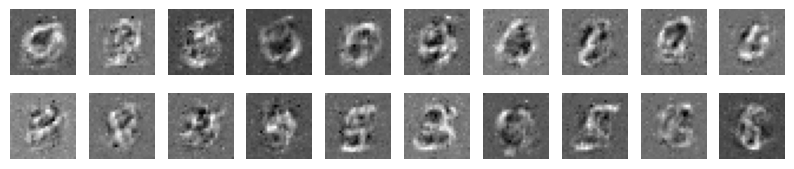

Epoch 11 completed. Train Log Likelihood: -927.2794799804688. Validation Log Likelihood: 914.8894454956055
Epoch 12 completed. Train Log Likelihood: -1081.4019775390625. Validation Log Likelihood: 1030.7804580688476
Epoch 13 completed. Train Log Likelihood: -1159.326171875. Validation Log Likelihood: 1139.1815338134766
Epoch 14 completed. Train Log Likelihood: -1251.168701171875. Validation Log Likelihood: 1234.731411743164
Epoch 15 completed. Train Log Likelihood: -1375.6273193359375. Validation Log Likelihood: 1322.5509399414063
Epoch 16 completed. Train Log Likelihood: -1429.060546875. Validation Log Likelihood: 1403.758563232422
Epoch 17 completed. Train Log Likelihood: -1485.6676025390625. Validation Log Likelihood: 1472.5168365478517
Epoch 18 completed. Train Log Likelihood: -1635.8814697265625. Validation Log Likelihood: 1537.959420776367
Epoch 19 completed. Train Log Likelihood: -1661.8543701171875. Validation Log Likelihood: 1594.7470764160157
Epoch 20 completed. Train Log Lik

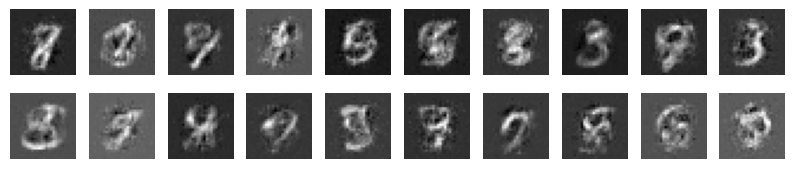

Epoch 21 completed. Train Log Likelihood: -1740.3387451171875. Validation Log Likelihood: 1679.7571197509765
Epoch 22 completed. Train Log Likelihood: -1777.6845703125. Validation Log Likelihood: 1711.8353637695313
Epoch 23 completed. Train Log Likelihood: -1843.82177734375. Validation Log Likelihood: 1743.2119842529296
Epoch 24 completed. Train Log Likelihood: -1886.4017333984375. Validation Log Likelihood: 1750.5926818847656
Epoch 25 completed. Train Log Likelihood: -1857.52734375. Validation Log Likelihood: 1768.5538055419922
Epoch 26 completed. Train Log Likelihood: -1891.2242431640625. Validation Log Likelihood: 1785.6762329101562
Epoch 27 completed. Train Log Likelihood: -1963.9033203125. Validation Log Likelihood: 1783.7447326660156
Epoch 28 completed. Train Log Likelihood: -1919.6175537109375. Validation Log Likelihood: 1799.9234649658204
Epoch 29 completed. Train Log Likelihood: -1942.5731201171875. Validation Log Likelihood: 1795.7606811523438
Epoch 30 completed. Train Log Li

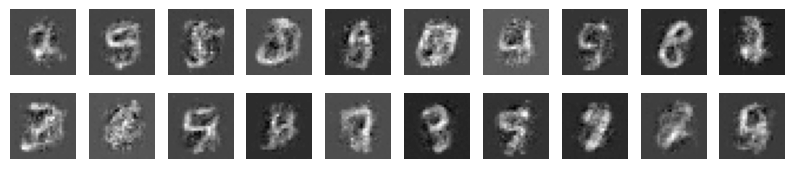

Epoch 31 completed. Train Log Likelihood: -1923.5406494140625. Validation Log Likelihood: 1812.2344818115234
Epoch 32 completed. Train Log Likelihood: -2067.027587890625. Validation Log Likelihood: 1799.7418243408204
Epoch 33 completed. Train Log Likelihood: -2020.6978759765625. Validation Log Likelihood: 1803.3158142089844
Epoch 34 completed. Train Log Likelihood: -2165.7841796875. Validation Log Likelihood: 1790.855551147461
Epoch 35 completed. Train Log Likelihood: -2082.811767578125. Validation Log Likelihood: 1789.148648071289
Epoch 36 completed. Train Log Likelihood: -2060.36181640625. Validation Log Likelihood: 1784.1514221191405
Epoch 37 completed. Train Log Likelihood: -2009.8436279296875. Validation Log Likelihood: 1771.6975708007812
Epoch 38 completed. Train Log Likelihood: -2157.133056640625. Validation Log Likelihood: 1762.9449127197265
Epoch 39 completed. Train Log Likelihood: -2152.125732421875. Validation Log Likelihood: 1761.5660186767577
Epoch 40 completed. Train Log 

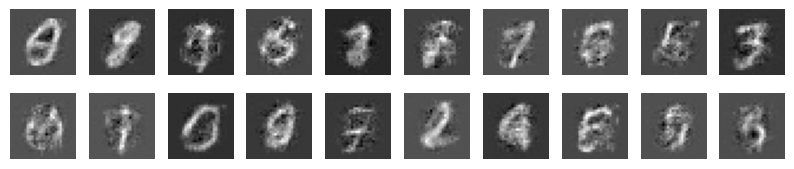

Epoch 41 completed. Train Log Likelihood: -2111.973876953125. Validation Log Likelihood: 1749.3218048095703
Epoch 42 completed. Train Log Likelihood: -2102.3408203125. Validation Log Likelihood: 1740.9387420654298
Epoch 43 completed. Train Log Likelihood: -2162.395751953125. Validation Log Likelihood: 1722.749789428711
Epoch 44 completed. Train Log Likelihood: -2146.678466796875. Validation Log Likelihood: 1708.8910858154297
Epoch 45 completed. Train Log Likelihood: -2174.187744140625. Validation Log Likelihood: 1719.604315185547
Epoch 46 completed. Train Log Likelihood: -2166.197509765625. Validation Log Likelihood: 1688.5489044189453
Epoch 47 completed. Train Log Likelihood: -2105.015380859375. Validation Log Likelihood: 1676.6317962646485
Epoch 48 completed. Train Log Likelihood: -2247.077880859375. Validation Log Likelihood: 1661.2372192382813
Epoch 49 completed. Train Log Likelihood: -2116.4326171875. Validation Log Likelihood: 1654.9727020263672


In [8]:
train_model(input_data_size, num_hidden_units, num_hidden_layer, num_epochs=50)

Epoch 0 completed. Train Log Likelihood: 902.9949340820312. Validation Log Likelihood: -902.3479019165039
Epoch 1 completed. Train Log Likelihood: 718.525390625. Validation Log Likelihood: -718.9653091430664
Epoch 2 completed. Train Log Likelihood: 537.5831909179688. Validation Log Likelihood: -537.4592758178711
Epoch 3 completed. Train Log Likelihood: 357.3028564453125. Validation Log Likelihood: -358.1116424560547
Epoch 4 completed. Train Log Likelihood: 179.8382110595703. Validation Log Likelihood: -180.50942192077636
Epoch 5 completed. Train Log Likelihood: 5.62231969833374. Validation Log Likelihood: -6.419962978363037
Epoch 6 completed. Train Log Likelihood: -167.20582580566406. Validation Log Likelihood: 163.67839393615722
Epoch 7 completed. Train Log Likelihood: -332.9226989746094. Validation Log Likelihood: 329.0676414489746
Epoch 8 completed. Train Log Likelihood: -496.7598571777344. Validation Log Likelihood: 486.0201385498047
Epoch 9 completed. Train Log Likelihood: -637.32

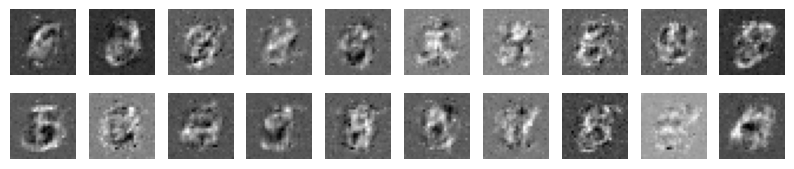

Epoch 11 completed. Train Log Likelihood: -925.270751953125. Validation Log Likelihood: 902.8857574462891
Epoch 12 completed. Train Log Likelihood: -1042.5029296875. Validation Log Likelihood: 1022.7170547485351
Epoch 13 completed. Train Log Likelihood: -1158.6441650390625. Validation Log Likelihood: 1132.562936401367
Epoch 14 completed. Train Log Likelihood: -1276.537353515625. Validation Log Likelihood: 1228.072998046875
Epoch 15 completed. Train Log Likelihood: -1366.86328125. Validation Log Likelihood: 1319.280191040039
Epoch 16 completed. Train Log Likelihood: -1433.76025390625. Validation Log Likelihood: 1397.5272216796875
Epoch 17 completed. Train Log Likelihood: -1481.83544921875. Validation Log Likelihood: 1466.296939086914
Epoch 18 completed. Train Log Likelihood: -1610.1373291015625. Validation Log Likelihood: 1534.2530944824218
Epoch 19 completed. Train Log Likelihood: -1638.4320068359375. Validation Log Likelihood: 1584.8246765136719
Epoch 20 completed. Train Log Likelihoo

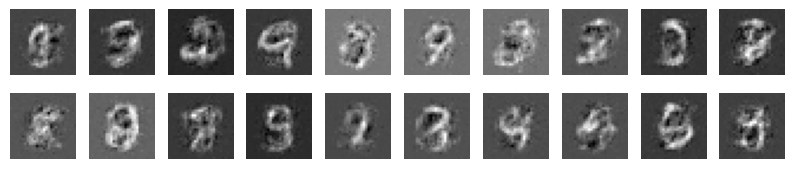

Epoch 21 completed. Train Log Likelihood: -1716.0892333984375. Validation Log Likelihood: 1674.3722717285157
Epoch 22 completed. Train Log Likelihood: -1784.5673828125. Validation Log Likelihood: 1709.5628662109375
Epoch 23 completed. Train Log Likelihood: -1860.6533203125. Validation Log Likelihood: 1728.8755615234375
Epoch 24 completed. Train Log Likelihood: -1814.6370849609375. Validation Log Likelihood: 1749.4064849853517
Epoch 25 completed. Train Log Likelihood: -1906.7427978515625. Validation Log Likelihood: 1764.1389892578125
Epoch 26 completed. Train Log Likelihood: -1861.52783203125. Validation Log Likelihood: 1790.3393829345703
Epoch 27 completed. Train Log Likelihood: -1933.7281494140625. Validation Log Likelihood: 1799.2068237304688
Epoch 28 completed. Train Log Likelihood: -1980.3037109375. Validation Log Likelihood: 1812.5340881347656
Epoch 29 completed. Train Log Likelihood: -1865.4964599609375. Validation Log Likelihood: 1814.9065856933594
Epoch 30 completed. Train Log 

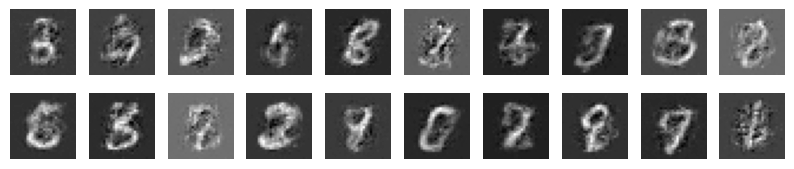

Epoch 31 completed. Train Log Likelihood: -2066.81982421875. Validation Log Likelihood: 1835.9767517089845
Epoch 32 completed. Train Log Likelihood: -2045.2601318359375. Validation Log Likelihood: 1841.0661529541017
Epoch 33 completed. Train Log Likelihood: -2078.842529296875. Validation Log Likelihood: 1836.3973083496094
Epoch 34 completed. Train Log Likelihood: -1975.1536865234375. Validation Log Likelihood: 1828.6389068603517
Epoch 35 completed. Train Log Likelihood: -2053.587158203125. Validation Log Likelihood: 1827.1592681884765
Epoch 36 completed. Train Log Likelihood: -2084.52587890625. Validation Log Likelihood: 1812.591845703125
Epoch 37 completed. Train Log Likelihood: -2193.968017578125. Validation Log Likelihood: 1802.1459228515625
Epoch 38 completed. Train Log Likelihood: -2091.62646484375. Validation Log Likelihood: 1797.0073455810548
Epoch 39 completed. Train Log Likelihood: -2021.22802734375. Validation Log Likelihood: 1787.052752685547
Epoch 40 completed. Train Log Li

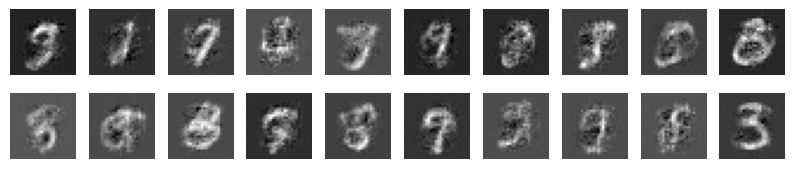

Epoch 41 completed. Train Log Likelihood: -2154.88671875. Validation Log Likelihood: 1781.7716857910157
Epoch 42 completed. Train Log Likelihood: -2240.630615234375. Validation Log Likelihood: 1777.7451629638672
Epoch 43 completed. Train Log Likelihood: -2171.55078125. Validation Log Likelihood: 1764.4998291015625
Epoch 44 completed. Train Log Likelihood: -2239.445068359375. Validation Log Likelihood: 1737.356427001953
Epoch 45 completed. Train Log Likelihood: -2222.675048828125. Validation Log Likelihood: 1736.1388946533202
Epoch 46 completed. Train Log Likelihood: -2275.478515625. Validation Log Likelihood: 1707.9060974121094
Epoch 47 completed. Train Log Likelihood: -2252.148681640625. Validation Log Likelihood: 1704.2646759033203
Epoch 48 completed. Train Log Likelihood: -2264.69677734375. Validation Log Likelihood: 1704.025894165039
Epoch 49 completed. Train Log Likelihood: -2282.200927734375. Validation Log Likelihood: 1686.5990051269532
Epoch 50 completed. Train Log Likelihood: 

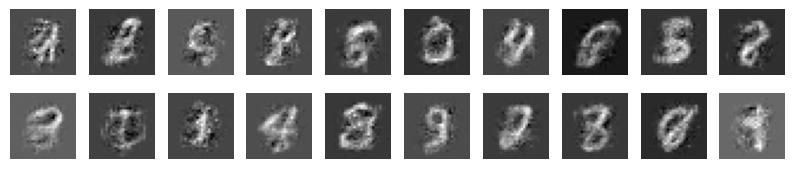

Epoch 51 completed. Train Log Likelihood: -2179.558349609375. Validation Log Likelihood: 1663.769384765625
Epoch 52 completed. Train Log Likelihood: -2246.013916015625. Validation Log Likelihood: 1649.373486328125
Epoch 53 completed. Train Log Likelihood: -2229.46923828125. Validation Log Likelihood: 1635.3117553710938
Epoch 54 completed. Train Log Likelihood: -2258.958740234375. Validation Log Likelihood: 1628.4270812988282
Epoch 55 completed. Train Log Likelihood: -2245.414306640625. Validation Log Likelihood: 1606.93154296875
Epoch 56 completed. Train Log Likelihood: -2097.740966796875. Validation Log Likelihood: 1599.8945098876952
Epoch 57 completed. Train Log Likelihood: -2224.365234375. Validation Log Likelihood: 1580.4584228515625
Epoch 58 completed. Train Log Likelihood: -2338.462158203125. Validation Log Likelihood: 1575.260302734375
Epoch 59 completed. Train Log Likelihood: -2280.80615234375. Validation Log Likelihood: 1559.8251373291016
Epoch 60 completed. Train Log Likeliho

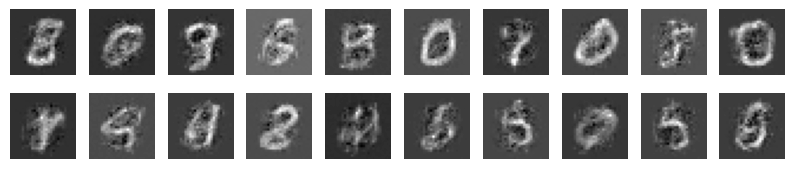

Epoch 61 completed. Train Log Likelihood: -2351.654296875. Validation Log Likelihood: 1529.8180114746094
Epoch 62 completed. Train Log Likelihood: -2307.56640625. Validation Log Likelihood: 1521.625192260742
Epoch 63 completed. Train Log Likelihood: -2324.378662109375. Validation Log Likelihood: 1512.5720184326171
Epoch 64 completed. Train Log Likelihood: -2377.158447265625. Validation Log Likelihood: 1525.8567749023437
Epoch 65 completed. Train Log Likelihood: -2313.8349609375. Validation Log Likelihood: 1497.9373107910155
Epoch 66 completed. Train Log Likelihood: -2272.295654296875. Validation Log Likelihood: 1484.9345275878907
Epoch 67 completed. Train Log Likelihood: -2290.053955078125. Validation Log Likelihood: 1513.7249389648437
Epoch 68 completed. Train Log Likelihood: -2177.150146484375. Validation Log Likelihood: 1495.1868133544922
Epoch 69 completed. Train Log Likelihood: -2395.708740234375. Validation Log Likelihood: 1522.7826904296876
Epoch 70 completed. Train Log Likeliho

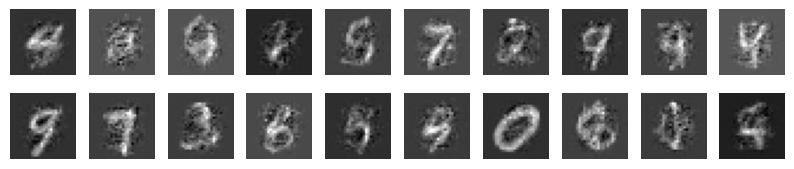

Epoch 71 completed. Train Log Likelihood: -2277.409423828125. Validation Log Likelihood: 1482.1214904785156
Epoch 72 completed. Train Log Likelihood: -2345.966064453125. Validation Log Likelihood: 1460.2592498779297
Epoch 73 completed. Train Log Likelihood: -2260.95703125. Validation Log Likelihood: 1431.8319519042968
Epoch 74 completed. Train Log Likelihood: -2337.776611328125. Validation Log Likelihood: 1427.2440063476563
Epoch 75 completed. Train Log Likelihood: -2366.8388671875. Validation Log Likelihood: 1409.0270599365235
Epoch 76 completed. Train Log Likelihood: -2297.187744140625. Validation Log Likelihood: 1412.0516204833984
Epoch 77 completed. Train Log Likelihood: -2430.302490234375. Validation Log Likelihood: 1422.182080078125
Epoch 78 completed. Train Log Likelihood: -2272.44677734375. Validation Log Likelihood: 1400.773910522461
Epoch 79 completed. Train Log Likelihood: -2298.705810546875. Validation Log Likelihood: 1401.7735687255858
Epoch 80 completed. Train Log Likelih

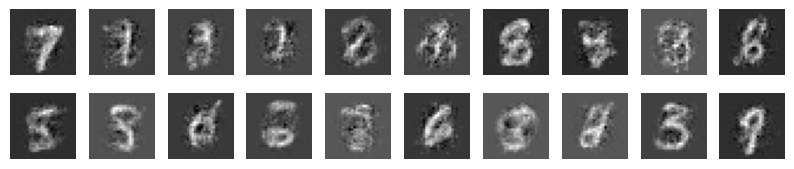

Epoch 81 completed. Train Log Likelihood: -2390.925048828125. Validation Log Likelihood: 1383.5074096679687
Epoch 82 completed. Train Log Likelihood: -2339.4931640625. Validation Log Likelihood: 1429.7026000976562
Epoch 83 completed. Train Log Likelihood: -2316.482666015625. Validation Log Likelihood: 1398.9271240234375
Epoch 84 completed. Train Log Likelihood: -2382.261474609375. Validation Log Likelihood: 1443.375634765625
Epoch 85 completed. Train Log Likelihood: -2431.021240234375. Validation Log Likelihood: 1379.1302215576172
Epoch 86 completed. Train Log Likelihood: -2276.827392578125. Validation Log Likelihood: 1427.1018493652343
Epoch 87 completed. Train Log Likelihood: -2443.993408203125. Validation Log Likelihood: 1394.7925201416015
Epoch 88 completed. Train Log Likelihood: -2390.546875. Validation Log Likelihood: 1392.6923034667968
Epoch 89 completed. Train Log Likelihood: -2387.719970703125. Validation Log Likelihood: 1413.4515472412108
Epoch 90 completed. Train Log Likelih

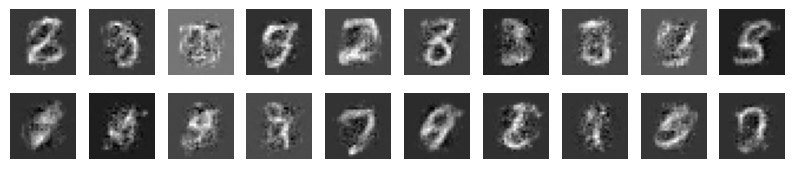

Epoch 91 completed. Train Log Likelihood: -2276.991455078125. Validation Log Likelihood: 1378.1431274414062
Epoch 92 completed. Train Log Likelihood: -2316.143310546875. Validation Log Likelihood: 1375.6275726318358
Epoch 93 completed. Train Log Likelihood: -2404.163330078125. Validation Log Likelihood: 1388.5749237060547
Epoch 94 completed. Train Log Likelihood: -2416.4169921875. Validation Log Likelihood: 1370.2914001464844
Epoch 95 completed. Train Log Likelihood: -2514.186767578125. Validation Log Likelihood: 1343.9252136230468
Epoch 96 completed. Train Log Likelihood: -2347.487548828125. Validation Log Likelihood: 1367.817221069336
Epoch 97 completed. Train Log Likelihood: -2427.425048828125. Validation Log Likelihood: 1327.0330505371094
Epoch 98 completed. Train Log Likelihood: -2334.343505859375. Validation Log Likelihood: 1322.4067749023438
Epoch 99 completed. Train Log Likelihood: -2287.212646484375. Validation Log Likelihood: 1319.968765258789


In [17]:
#lets train for 100 epochs

train_model(input_data_size, num_hidden_units, num_hidden_layer, num_epochs=100)